In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
import tensorflow.keras.backend as K

from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.losses import BinaryCrossentropy
import tensorflow_addons as tfa

from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import KFold
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.metrics import log_loss
from sklearn import preprocessing

from sklearn.decomposition import PCA, TruncatedSVD

from tqdm.notebook import tqdm

import math

In [2]:
# Load data
train_feature = pd.read_csv("../../Data/Mechanisms of Action (MoA) Prediction/train_features.csv")
test_feature = pd.read_csv("../../Data/Mechanisms of Action (MoA) Prediction/test_features.csv")
train_targets_scored = pd.read_csv("../../Data/Mechanisms of Action (MoA) Prediction/train_targets_scored.csv")
train_targets_nonscored = pd.read_csv("../../Data/Mechanisms of Action (MoA) Prediction/train_targets_nonscored.csv")
sub = pd.read_csv('../../Data/Mechanisms of Action (MoA) Prediction/sample_submission.csv')
data = train_feature.append(test_feature)

In [3]:
import random, os
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

    
seed_everything(seed=1)

In [4]:
def scaler_ss(train,test):
    
    features = train.columns[2:]
    scaler = preprocessing.StandardScaler()
    scaler.fit(pd.concat([train[features],test[features]],axis=0))
    train[features] = scaler.transform(train[features])
    test[features] = scaler.transform(test[features])
    
    return train, test, features

In [5]:
def scaler_mm(train,test):
    
    features = train.columns[2:]
    scaler = preprocessing.MinMaxScaler()
    scaler.fit(pd.concat([train[features],test[features]],axis=0))
    train[features] = scaler.transform(train[features])
    test[features] = scaler.transform(test[features])
    
    return train, test, features

In [6]:
GENES = [col for col in train_feature.columns  if col.startswith('g-')]
CELLS = [col for col in train_feature.columns  if col.startswith('c-')]

In [7]:
for col in tqdm(GENES+CELLS):
    transformer = QuantileTransformer(n_quantiles=250, random_state=0,
                                      output_distribution='normal')
    vec_len_train = len(train_feature[col].values)
    vec_len_test = len(test_feature[col].values)
    input_vec_train = train_feature[col].values.reshape(vec_len_train,1)
    input_vec_test = test_feature[col].values.reshape(vec_len_test,1)
    transformer.fit(input_vec_train)
    train_feature[col] = transformer.transform(input_vec_train).reshape(1,vec_len_train)[0]
    test_feature[col] = transformer.transform(input_vec_test).reshape(1,vec_len_test)[0]
    

In [8]:
# GENES PCA
n_comp = 660
data = pd.concat([train_feature[GENES],test_feature[GENES]], axis=0)
data_1 = (PCA(n_components=n_comp, random_state=42).fit_transform(data[GENES]))
train_1 = data_1[:train_feature.shape[0]]
test_1 = data_1[-test_feature.shape[0]:]

train_1 = pd.DataFrame(train_1, columns=[f'PCA-G{i}' for i in range(n_comp)])
test_1 = pd.DataFrame(test_1, columns=[f'PCA-G{i}' for i in range(n_comp)])

train_feature = pd.concat((train_feature, train_1), axis=1)
test_feature = pd.concat((test_feature, test_1), axis=1)

In [9]:
# CELLS PCA
n_comp = 66
data = pd.concat([train_feature[CELLS],test_feature[CELLS]], axis=0)
data_1 = (PCA(n_components=n_comp, random_state=42).fit_transform(data[CELLS]))
train_1 = data_1[:train_feature.shape[0]]
test_1 = data_1[-test_feature.shape[0]:]

train_1 = pd.DataFrame(train_1, columns=[f'PCA-C{i}' for i in range(n_comp)])
test_1 = pd.DataFrame(test_1, columns=[f'PCA-C{i}' for i in range(n_comp)])

train_feature = pd.concat((train_feature, train_1), axis=1)
test_feature = pd.concat((test_feature, test_1), axis=1)

In [10]:
# GENES SVD
n_comp = 550
data = pd.concat([train_feature[GENES],test_feature[GENES]], axis=0)
data_1 = (TruncatedSVD(n_components=n_comp, random_state=42).fit_transform(data[GENES]))
train_1 = data_1[:train_feature.shape[0]]
test_1 = data_1[-test_feature.shape[0]:]

train_1 = pd.DataFrame(train_1, columns=[f'SVD-G{i}' for i in range(n_comp)])
test_1 = pd.DataFrame(test_1, columns=[f'SVD-G{i}' for i in range(n_comp)])

train_feature = pd.concat((train_feature, train_1), axis=1)
test_feature = pd.concat((test_feature, test_1), axis=1)

In [11]:
# CELLS SVD
n_comp = 55
data = pd.concat([train_feature[CELLS],test_feature[CELLS]], axis=0)
data_1 = (TruncatedSVD(n_components=n_comp, random_state=42).fit_transform(data[CELLS]))
train_1 = data_1[:train_feature.shape[0]]
test_1 = data_1[-test_feature.shape[0]:]

train_1 = pd.DataFrame(train_1, columns=[f'SVD-C{i}' for i in range(n_comp)])
test_1 = pd.DataFrame(test_1, columns=[f'SVD-C{i}' for i in range(n_comp)])

train_feature = pd.concat((train_feature, train_1), axis=1)
test_feature = pd.concat((test_feature, test_1), axis=1)

In [12]:
def c_squared(train,test):
    features = list(train.columns[776:876])
    for _features in tqdm(features):
        train[f'{_features}_squared'] = train[_features]**2
        test[f'{_features}_squared'] = test[_features]**2
        
    return train, test
        

In [13]:
train_feature, test_feature = c_squared(train_feature, test_feature)

In [14]:
def c_cubed(train,test):
    features = list(train.columns[776:876])
    for _features in tqdm(features):
        train[f'{_features}_cubed'] = train[_features]**3
        test[f'{_features}_cubed'] = test[_features]**3
        
    return train, test
        

In [15]:
train_feature, test_feature = c_cubed(train_feature, test_feature)

In [16]:
def c_sqrt(train,test):
    features = list(train.columns[776:876])
    for _features in tqdm(features):
        train[f'{_features}_sqrt'] = train[_features]**0.5
        test[f'{_features}_sqrt'] = test[_features]**0.5
        
    return train, test
        

In [17]:
def scaler_rs(train,test):
    features = list(train.columns[4:])
    data = pd.concat([train[features], test[features]],axis=0)
    scaler = preprocessing.RobustScaler()
    scaler.fit(data)
    train[features] = scaler.transform(train[features])
    test[features] = scaler.transform(test[features])
    
    return train, test, features

In [18]:
print(f'New Train/Test Features Dataset Contains [{train_feature.shape[1]}] Features.')

New Train/Test Features Dataset Contains [2407] Features.


In [19]:
thresold = 0.98
var_thres = VarianceThreshold(thresold)
data = train_feature.append(test_feature)
data_transformed = var_thres.fit_transform(data.iloc[:,4:])

train_feature_transformed = data_transformed[:train_feature.shape[0]]
test_feature_transformed = data_transformed[-test_feature.shape[0]:]


train_feature = pd.DataFrame(train_feature[['sig_id','cp_type','cp_time','cp_dose']]
                             .values.reshape(-1, 4),columns=['sig_id','cp_type','cp_time','cp_dose'])

train_feature = pd.concat([train_feature, pd.DataFrame(train_feature_transformed)]
                          , axis=1)

test_feature = pd.DataFrame(test_feature[['sig_id','cp_type','cp_time','cp_dose']]
                            .values.reshape(-1, 4),columns=['sig_id','cp_type','cp_time','cp_dose'])

test_feature = pd.concat([test_feature, pd.DataFrame(test_feature_transformed)]
                          , axis=1)



In [20]:
print(f'Variance Threshold Select [{train_feature.shape[1]}] Features From [2407]]')

Variance Threshold Select [1312] Features From [2407]]


In [21]:
train = train_feature.copy()
target = train_targets_scored.copy()
test = test_feature.copy()

target = target[train['cp_type']!='ctl_vehicle'].reset_index(drop=True)
target.drop(['sig_id'], axis=1, inplace=True)

train = train[train['cp_type']!='ctl_vehicle'].reset_index(drop=True)
train.drop(['sig_id', 'cp_type'], axis=1, inplace=True)

test.drop(['sig_id', 'cp_type'], axis=1, inplace=True)

In [22]:
# data encoding
def preprocess(df):
#   df.loc[:,'cp_type'] =  df.loc[:,'cp_type'].map({'trt_cp' : 0,'ctl_vehicle' : 1})
#     df.drop(['cp_type'],axis=1,inplace=True)
    df.loc[:,'cp_dose'] = df.loc[:,'cp_dose'].map({'D1':0,'D2':1})
#     df.loc[:,'cp_time'] = df.loc[:,'cp_time'].map({24:0,48:1,72:2})
    df = pd.get_dummies(df,columns=['cp_dose','cp_time'])
#     del df['sig_id']
    return df

train = preprocess(train)
test = preprocess(test)
data = train.append(test)

In [23]:
np.mean(train.values), np.std(train.values), np.min(train.values), np.max(train.values)

(0.005417677156525093,
 3.7962507513874515,
 -140.55427154590373,
 140.55427155383887)

In [24]:
somthing_rate = 1e-3
P_MIN = somthing_rate
P_MAX = 1 - P_MIN

def loss_fn(yt, yp):
    yp = np.clip(yp, P_MIN, P_MAX)
    return log_loss(yt, yp, labels=[0,1])

NUM_FEATURES = train.shape[1]

In [25]:
def create_model(num_columns, hidden_layers=1500, SEED=None):
    model = tf.keras.Sequential([tf.keras.layers.Input(num_columns)])
    initializer = tf.keras.initializers.VarianceScaling(scale=math.sqrt(5)
                                                        , mode='fan_in'
                                                        , distribution='uniform'
                                                        , seed=SEED)#math.sqrt(6. / n) 
    
    model.add(tf.keras.layers.BatchNormalization())
    #model.add(tf.keras.layers.Dropout(0.4))
    model.add(tfa.layers.WeightNormalization(tf.keras.layers.Dense(hidden_layers
                                                                   , kernel_initializer=initializer)))
    #model.add(tf.keras.layers.Activation('elu'))
    model.add(tf.keras.layers.LeakyReLU())
    
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.2654321))
    model.add(tfa.layers.WeightNormalization(tf.keras.layers.Dense(750
                                                                   , kernel_initializer=initializer)))
    #model.add(tf.keras.layers.Activation('elu'))
    model.add(tf.keras.layers.LeakyReLU())

    #============ Final Layer =================
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.2678923456789))
    model.add(tfa.layers.WeightNormalization(tf.keras.layers.Dense(206
                                                                   , kernel_initializer='uniform')))
    model.add(tf.keras.layers.Activation('sigmoid'))
    
    tfa_opt = tfa.optimizers.Lookahead(tfa.optimizers.AdamW(lr = 1e-3, weight_decay = 1e-5), sync_period=10)
    tf_opt = tfa.optimizers.Lookahead(tf.keras.optimizers.Adam(learning_rate=1e-3, epsilon=1e-7), sync_period=10)
    
    model.compile(optimizer=tfa_opt, 
                  loss=BinaryCrossentropy(),
                  metrics=BinaryCrossentropy(label_smoothing=somthing_rate)
                  )
    return model

In [26]:
# Use All feats as top feats
top_feats = [i for i in range(train.shape[1])]
print("Top feats length:",len(top_feats))

Top feats length: 1313


In [27]:
#Test min and max weights range
initializer = tf.keras.initializers.VarianceScaling(scale=0.2, mode='fan_in', distribution='uniform', seed=None) #math.sqrt(3 * 0.2 / n) 
valuesi = initializer(shape=(1319, 1600))
valueso = initializer(shape=(1600, 206))

valuesi.numpy().max(), valueso.numpy().max()

(0.021328133, 0.019364549)

In [28]:
def metric(y_true,y_pred):
    metrics=[]
    for _target in train_targets_scored.columns[1:]:
        metrics.append(loss_fn(y_true.loc[:,_target],y_pred.loc[:,_target].astype(float)))
        
    return np.mean(metrics)

In [37]:
N_starts = 1

train_targets = target
res = train_targets.copy()

sub.loc[:,train_targets.columns] = 0
res.loc[:,train_targets.columns] = 0

historys = dict()

seed_everything(seed=42)

for seed in range(N_starts):
    for fold, (tr,te) in enumerate(MultilabelStratifiedKFold(n_splits=5
                                                             , random_state=seed**2
                                                             , shuffle = True).split(train_targets,train_targets)):
        print(f"======{train_targets.values[tr].shape}========{train_targets.values[te].shape}=====")
        print(f'Seed: {seed} => Fold: {fold}')
        checkpoint_path = f'repeat:{seed}_Fold:{fold}.hdf5'
        reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.2, min_lr=1e-6
                                           , patience=4, verbose=1, mode='min')
        cb_checkpt = ModelCheckpoint(checkpoint_path, monitor = 'val_loss', verbose = 1
                                     , save_best_only = True, save_weights_only = True
                                     , mode = 'min')
        early = EarlyStopping(monitor="val_loss", mode="min", restore_best_weights=True
                              , patience= 10, verbose = 1)
        model = create_model(len(top_feats), SEED=seed**2)
        history = model.fit(train.values[tr][:, top_feats],train_targets.values[tr]
                            ,validation_data=(train.values[te][:, top_feats], train_targets.values[te])
                            ,epochs=5, batch_size=128,callbacks=[reduce_lr_loss, cb_checkpt, early]
                            , verbose=2)
        
        historys[f'history_seed_{seed+1}_fold_{fold+1}'] = history
        print("Model History Saved.")
        model.load_weights(checkpoint_path)
        test_predict = model.predict(test.values[:, top_feats])
        val_predict = model.predict(train.values[te][:, top_feats])
        
        sub.loc[:, train_targets.columns] += test_predict
        res.loc[te, train_targets.columns] += val_predict
        
        print(f'OOF Metric For SEED {seed} => FOLD {fold} : {metric(train_targets.loc[te, train_targets.columns], pd.DataFrame(val_predict, columns=train_targets.columns))}')
        print('+-' * 10)



======(17559, 206)========(4389, 206)=====
Seed: 0 => Fold: 0
Epoch 1/5

Epoch 00001: val_loss improved from inf to 0.16759, saving model to repeat:0_Fold:0.hdf5
138/138 - 18s - loss: 0.5459 - binary_crossentropy: 0.5440 - val_loss: 0.1676 - val_binary_crossentropy: 0.1686
Epoch 2/5

Epoch 00002: val_loss improved from 0.16759 to 0.04247, saving model to repeat:0_Fold:0.hdf5
138/138 - 17s - loss: 0.0941 - binary_crossentropy: 0.0951 - val_loss: 0.0425 - val_binary_crossentropy: 0.0442
Epoch 3/5

Epoch 00003: val_loss improved from 0.04247 to 0.02780, saving model to repeat:0_Fold:0.hdf5
138/138 - 17s - loss: 0.0360 - binary_crossentropy: 0.0380 - val_loss: 0.0278 - val_binary_crossentropy: 0.0299
Epoch 4/5

Epoch 00004: val_loss improved from 0.02780 to 0.02305, saving model to repeat:0_Fold:0.hdf5
138/138 - 18s - loss: 0.0265 - binary_crossentropy: 0.0288 - val_loss: 0.0230 - val_binary_crossentropy: 0.0255
Epoch 5/5

Epoch 00005: val_loss improved from 0.02305 to 0.02114, saving mode

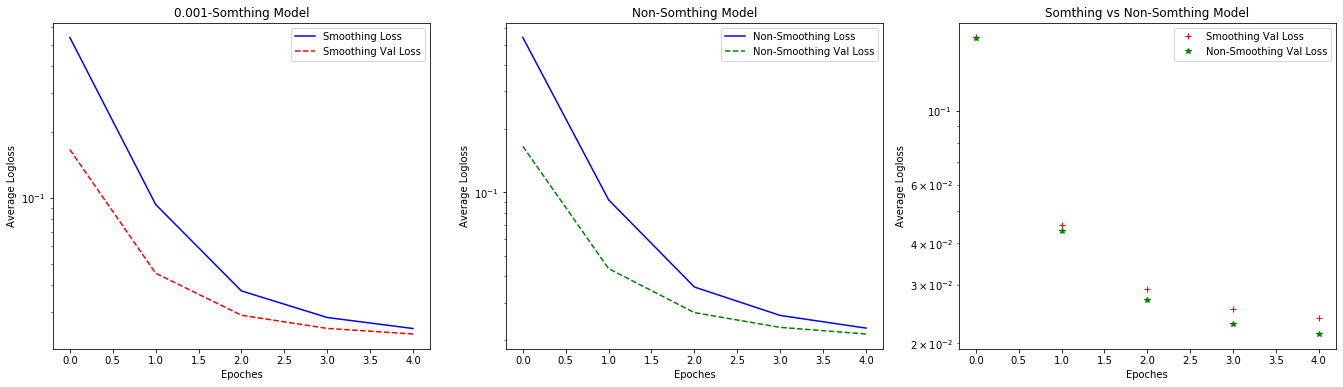

In [38]:
for k,v in historys.items():
    loss = []
    val_loss = []
    loss.append(v.history['loss'][:35])
    val_loss.append(v.history['val_loss'][:35])
    
# Show Model loss in plots
for k,v in historys.items():
    bin_loss = []
    bin_val_loss = []
    bin_loss.append(v.history['binary_crossentropy'][:35])
    bin_val_loss.append(v.history['val_binary_crossentropy'][:35])
    
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 3, figsize = (23, 6))

ax[0].plot(np.mean(bin_loss, axis=0), 'b', label='Smoothing Loss')
ax[0].plot(np.mean(bin_val_loss, axis=0), 'r--', label='Smoothing Val Loss')
ax[0].set(title=f'{somthing_rate}-Somthing Model', yscale='log', yticks=[1,1e-1,1e-2], xlabel='Epoches', ylabel='Average Logloss')
ax[0].legend()

ax[1].plot(np.mean(loss, axis=0), 'b', label='Non-Smoothing Loss')
ax[1].plot(np.mean(val_loss, axis=0), 'g--',label='Non-Smoothing Val Loss')
ax[1].set(title='Non-Somthing Model', yscale='log', yticks=[1,1e-1,1e-2], xlabel='Epoches', ylabel='Average Logloss')
ax[1].legend()


ax[2].plot(np.mean(bin_val_loss, axis=0), 'r+', label='Smoothing Val Loss')
ax[2].plot(np.mean(val_loss, axis=0), 'g*',label='Non-Smoothing Val Loss')
ax[2].set(title='Somthing vs Non-Somthing Model', yscale='log', xlabel='Epoches', ylabel='Average Logloss')
ax[2].legend()

In [40]:
sub.loc[:, train_targets.columns] /= ((fold+1) * N_starts)
res.loc[:, train_targets.columns] /= N_starts

In [5]:
import torch